In [2]:
using PyPlot, PyCall
using JuMP, Ipopt, Statistics
inset_locator = pyimport("mpl_toolkits.axes_grid.inset_locator");
mpl = pyimport("matplotlib");

In [7]:
include("../src/model.jl");
include("../src/diagnostics.jl");
include("../src/optimization.jl");
include("../src/plotting.jl");
include("../src/defaults.jl");

### Make figures from default model configuration for manuscript

#### Approach 1: Cost-benefit analysis

In [3]:
model = ClimateModel();
@time optimize_controls!(model, obj_option = "net_benefit");


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solve_Succeeded
 36.786301 seconds (111.94 M allocations: 6.363 GiB, 6.14% gc time)


In [4]:
stat_dict = Dict("mitigate" => [], "remove" => [], "geoeng" => [], "adapt" => [], "maxTnoG" => [], "maxT" => [], "maxCO2" => [])
ρdict = Dict()
ρs = 0.:0.005:0.1

for ρ in ρs
    tmp_model = ClimateModel();
    tmp_model.economics.utility_discount_rate = ρ
    @time optimize_controls!(tmp_model, obj_option = "net_benefit");
    ρdict[ρ] = tmp_model
    
    append!(stat_dict["mitigate"], mean(tmp_model.controls.mitigate))
    append!(stat_dict["remove"], mean(tmp_model.controls.remove))
    append!(stat_dict["adapt"], mean(tmp_model.controls.adapt))
    append!(stat_dict["geoeng"], mean(tmp_model.controls.geoeng))
    append!(stat_dict["maxTnoG"], maximum(δT_no_geoeng(tmp_model)))
    append!(stat_dict["maxT"], maximum(δT(tmp_model)))
    append!(stat_dict["maxCO2"], maximum(CO₂(tmp_model)))
end

Solve_Succeeded
  0.043529 seconds (110.00 k allocations: 4.310 MiB)
Solve_Succeeded
  0.045125 seconds (110.14 k allocations: 4.319 MiB)
Solve_Succeeded
  0.074948 seconds (102.10 k allocations: 4.158 MiB, 41.06% gc time)
Solve_Succeeded
  0.043487 seconds (102.25 k allocations: 4.168 MiB)
Solve_Succeeded
  0.043592 seconds (100.76 k allocations: 4.126 MiB)
Solve_Succeeded
  0.040804 seconds (100.76 k allocations: 4.126 MiB)
Solve_Succeeded
  0.042130 seconds (104.85 k allocations: 4.212 MiB)
Solve_Succeeded
  0.051425 seconds (104.70 k allocations: 4.202 MiB)
Solve_Succeeded
  0.049357 seconds (102.25 k allocations: 4.167 MiB)
Solve_Succeeded
  0.052016 seconds (102.11 k allocations: 4.158 MiB)
Solve_Succeeded
  0.048234 seconds (98.31 k allocations: 4.091 MiB)
Solve_Succeeded
  0.075447 seconds (117.88 k allocations: 4.462 MiB)
Solve_Succeeded
  0.713206 seconds (981.66 k allocations: 21.120 MiB)
Solve_Succeeded
  1.229203 seconds (1.56 M allocations: 32.352 MiB, 1.62% gc time)
Solv

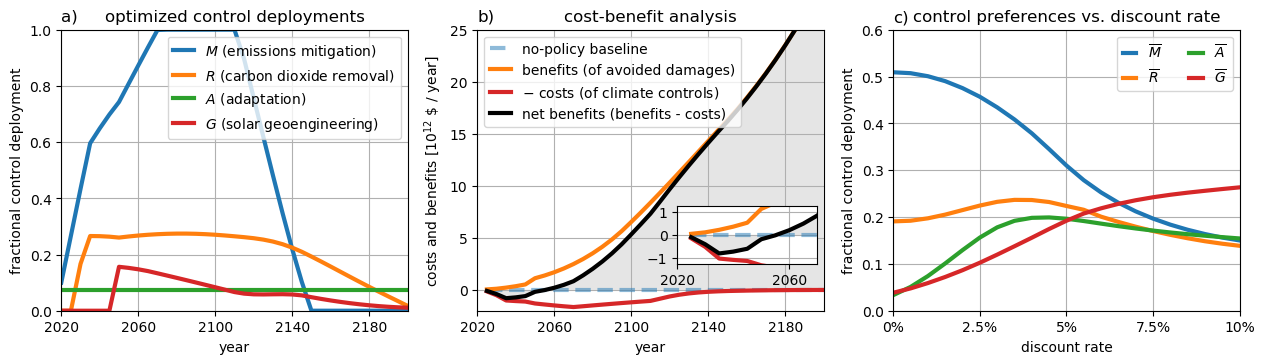

Maximum warming: 1.2839736769477197

In [17]:
fig = figure(figsize=(12.75,3.75))

fig.add_subplot(1,3,1)
plot_controls(model)
legend(handlelength=1.5, loc="upper right")
add_label("a)")
xticks(model.domain[1]:40.:2200.)

ax = fig.add_subplot(1,3,2)
plot_benefits(model)
legend(handlelength=1.5, loc="upper left")
add_label("b)")
ylim([-2., 25.])
xticks(model.domain[1]:40.:2200.)

ax = fig.add_subplot(1,3,3)
plot(ρs, stat_dict["mitigate"], label=L"$\overline{M}$")
plot(ρs, stat_dict["remove"], label=L"$\overline{R}$")
plot(ρs, stat_dict["adapt"], label=L"$\overline{A}$")
plot(ρs, stat_dict["geoeng"], label=L"$\overline{G}$")
legend(ncol=2, handlelength=1.)
ylim([0, 0.6])
xlim([0., 0.1])
xticks([0., 0.025, 0.05, 0.075, 0.1], ["0%", "2.5%", "5%", "7.5%", "10%"])
grid(true)
ylabel("fractional control deployment")
title("control preferences vs. discount rate")
title("c)", loc="left")
xlabel("discount rate")

iax = fig.add_axes([0.535, 0.28, 0.11, 0.155])
sca(iax)
plot_benefits(model)
ylabel("")
xlabel("")
ylim([-1.25, 1.25])
xlim([2020,2070])
title("")

tight_layout()
savefig("../figures/default-benefits_controls_and_benefits.pdf", dpi=150, bbox_inches="tight")

print("Maximum warming: ", maximum(δT_adapt(model)))

#### Approach 2: Avoiding damage thresholds

In [4]:
model = ClimateModel();
@time optimize_controls!(model);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solve_Succeeded
 36.988086 seconds (111.93 M allocations: 6.361 GiB, 5.69% gc time)


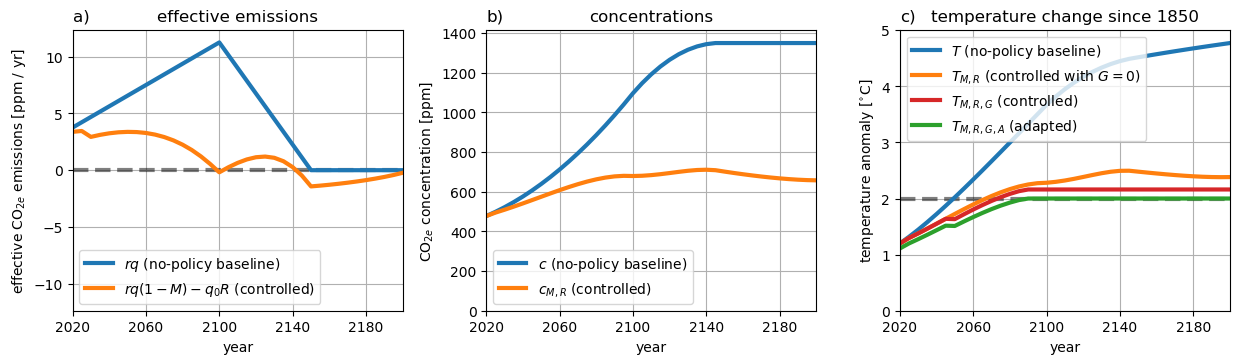

In [5]:
figure(figsize=(12.5,3.75))

subplot(1,3,1)
plot_emissions(model)
legend()
add_label("a)")
subplot(1,3,2)
plot_concentrations(model)
legend()
add_label("b)")
subplot(1,3,3)
plot_temperatures(model)
legend(loc="upper left")
add_label("c)")
tight_layout()
savefig("../figures/default-temp_carbon_and_temperatures.pdf", dpi=150, bbox_inches="tight")

In [15]:
function f_asymp(α, mitigate_cost_limit, mitigate_cost_factor)
    idx = α .>= mitigate_cost_limit
    ret = α .^ 2. ./ (1. .- exp.(mitigate_cost_factor *(α .- mitigate_cost_limit)))
    ret[idx] .= NaN
    return ret
end
α = 0.:0.002:1.0

0.0:0.002:1.0

In [35]:
tmp_model = ClimateModel();
@time m = optimize_controls!(
    tmp_model, obj_option = "net_benefit",
    mitigate_cost_limit = 1.,
    mitigate_cost_factor = 2.,
);


Solve_Succeeded
  0.048890 seconds (116.63 k allocations: 4.566 MiB)


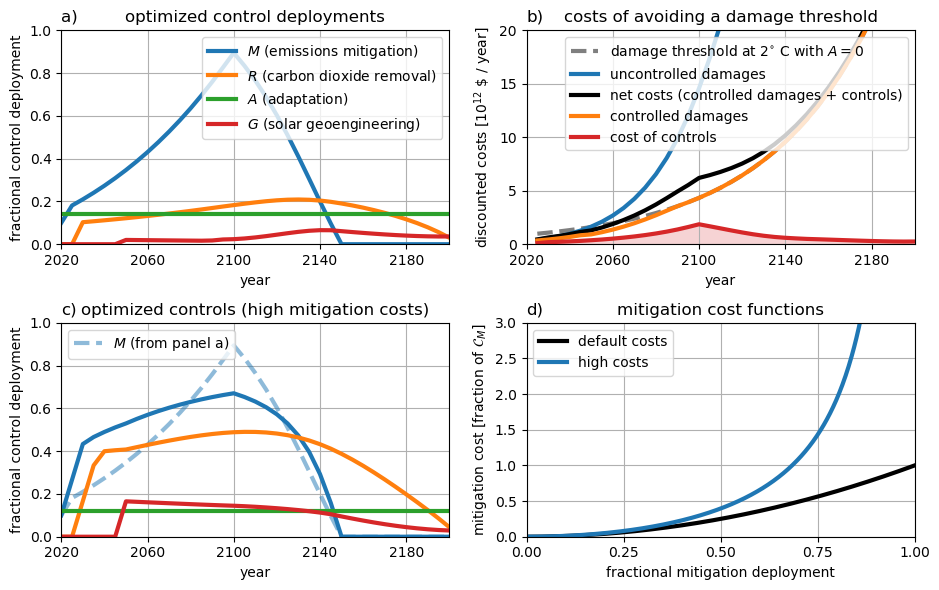

Net Present Control Costs: 54.73534601538341

In [52]:
figure(figsize=(9.5,6))

subplot(2,2,1)
plot_controls(model)
legend(loc="upper right")
title("a)", loc="left")

subplot(2,2,2)
plot_damages(model)
legend(loc="upper right")
title("b)", loc="left")
ylim([0, 20])

subplot(2,2,3)
plot(model.domain, model.controls.mitigate, "C0--", alpha=0.5, label=L"$M$ (from panel a)")
legend(loc="upper left")
plot_controls(tmp_model)
title("c)", loc="left")
title("optimized controls (high mitigation costs)")

subplot(2,2,4)
plot(α, α.^2, "k-", label="default costs")
plot(α, f_asymp(α, 1., 2.), label="high costs")
xlim([0,1])
ylim([0,3])
xticks([0., 0.25, 0.5, 0.75, 1.])
legend(loc="upper left")
ylabel(L"mitigation cost [fraction of $\mathcal{C}_{M}$]")
xlabel("fractional mitigation deployment")
title("mitigation cost functions")
title("d)", loc="left")
grid(true)

tight_layout()
savefig("../figures/default-temp_controls_and_damages.pdf", dpi=150, bbox_inches="tight")

print("Net Present Control Costs: ", discounted_total_control_cost(model))